# Panan005 Along Slope Anomaly

In [1]:
import intake
import glob
import dask.distributed as dsk
import matplotlib.pyplot as plt
import xarray as xr
import cf_xarray as cfxr
import numpy as np
import xesmf as xe
from pathlib import Path
import xgcm

import cmocean as cm
import cartopy.crs as ccrs

import cartopy.feature as cft
import matplotlib.path as mpath

import warnings # ignore these warnings
warnings.filterwarnings("ignore", category = FutureWarning)
warnings.filterwarnings("ignore", category = UserWarning)
warnings.filterwarnings("ignore", category = RuntimeWarning)

In [2]:
#Starting a dask client
from os import environ
environ["PYTHONWARNINGS"] = "ignore"

from dask.distributed import Client
client = Client(threads_per_worker=1)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/40137/status,
Dashboard: /proxy/40137/status,Workers: 28
Total threads: 28,Total memory: 125.19 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:46439,Workers: 28
Dashboard: /proxy/40137/status,Total threads: 28
Started: Just now,Total memory: 125.19 GiB
Comm: tcp://127.0.0.1:35841,Total threads: 1
Dashboard: /proxy/44247/status,Memory: 4.47 GiB
Nanny: tcp://127.0.0.1:34745,


2025-10-10 13:16:16,066 - distributed.nanny.memory - WARNING - Worker tcp://127.0.0.1:45305 (pid=1661262) exceeded 95% memory budget. Restarting...
2025-10-10 13:16:16,496 - distributed.scheduler - WARNING - Removing worker 'tcp://127.0.0.1:45305' caused the cluster to lose already computed task(s), which will be recomputed elsewhere: {('mean_chunk-e40a906330324e114f66bbd988cccd6b', 21, 0, 0, 2), ('mean_chunk-e40a906330324e114f66bbd988cccd6b', 43, 0, 0, 0), ('mean_chunk-e40a906330324e114f66bbd988cccd6b', 31, 0, 0, 1), ('rechunk-merge-69f99b45517051ce206d98eda18b1045', 0, 0, 3), ('mean_chunk-e40a906330324e114f66bbd988cccd6b', 11, 0, 0, 0), ('zeros_like-9b03e7ca44b0b9f8f9378c8bdc9544e7', 0, 1, 6), ('mean_chunk-e40a906330324e114f66bbd988cccd6b', 21, 0, 0, 1), ('mean_combine-partial-fe41b4b039754c478730362f46ebf8a0', 1, 0, 0, 7), ('mean_chunk-e40a906330324e114f66bbd988cccd6b', 43, 0, 0, 11), ('rechunk-merge-69f99b45517051ce206d98eda18b1045', 0, 0, 2), ('mean_chunk-e40a906330324e114f66bbd98

In [3]:
# Importing data
pathsC = np.sort(glob.glob('/g/data/ol01/outputs/mom6-panan/panant-005-zstar-ACCESSyr2/outpu*/*.ocean_month_z.nc'))[120:]
pathsM = np.sort(glob.glob('/g/data/g40/akm157/model_output/mom6-panan/panant-005-zstar-ssp126-MW-only/outpu*/*.ocean_month_z.nc'))[:60]

In [4]:
# Time variant variables
def preprocess(ds):
    ds = ds[['uo', 'vo','volcello']].sel(yh = slice(-80, -59),yq = slice(-80, -59), z_l = slice(None, 500))
    return ds

cont = xr.open_mfdataset(pathsC, preprocess = preprocess, chunks = 'auto')
melt = xr.open_mfdataset(pathsM, preprocess = preprocess, chunks = 'auto')

In [5]:
# Time mean (last 5 yrs)
uC = cont['uo'].sel(time=slice('2006-01-01','2010-12-31')).mean('time')
vC = cont['vo'].sel(time=slice('2006-01-01','2010-12-31')).mean('time')
uMW = melt['uo'].sel(time=slice('2006-01-01','2010-12-31')).mean('time')
vMW = melt['vo'].sel(time=slice('2006-01-01','2010-12-31')).mean('time')

In [12]:
cont_n = xr.merge([uC,vC])
cont_n= cont_n.isel(xq = slice(1, None))#, yq = slice(1, None))
pert_n = xr.merge([uMW,vMW])
pert_n= pert_n.isel(xq = slice(1, None))#, yq = slice(1, None))

In [13]:
path_to_ocean_static_C = Path('/g/data/ol01/outputs/mom6-panan/panant-005-zstar-ACCESSyr2/output021/19921001.ocean_static.nc')
ocean_static_C = xr.open_dataset(path_to_ocean_static_C)

ocean_static_C = ocean_static_C.sel(xq = cont_n['xq'], xh = cont_n['xh'], yq = cont_n['yq'], yh = cont_n['yh'])

In [14]:
grid_C = xgcm.Grid(ocean_static_C, coords = {'X': {'center': 'xh', 'right': 'xq'},
                                             'Y': {'center': 'yh', 'right': 'yq'}},
                                               periodic = ['X'])

In [15]:
path_to_ocean_static_MW = Path('/g/data/g40/akm157/model_output/mom6-panan/panant-005-zstar-ssp126-MW-only/output120/20010101.ocean_static.nc')
ocean_static_MW = xr.open_dataset(path_to_ocean_static_MW)

ocean_static_MW = ocean_static_C.sel(xq = cont_n['xq'], xh = cont_n['xh'], yq = cont_n['yq'], yh = cont_n['yh'])

In [16]:
grid_MW = xgcm.Grid(ocean_static_MW, coords = {'X': {'center': 'xh', 'right': 'xq'},
                                               'Y': {'center': 'yh', 'right': 'yq'}},
                                               periodic = ['X'])

In [17]:
dh_dx_C = grid_C.interp(grid_C.diff(ocean_static_C['deptho'], 'X') / ocean_static_C['dxCu'], 'Y')
dh_dy_C = grid_C.interp(grid_C.diff(ocean_static_C['deptho'], 'Y') / ocean_static_C['dyCv'], 'X')

In [18]:
dh_dx_C

<xarray.DataArray (yq: 967, xq: 7200)> Size: 28MB
array([[        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       ...,
       [ 0.00647635,  0.0087693 ,  0.01049709, ..., -0.01130929,
         0.0009448 ,  0.00338192],
       [ 0.00737227,  0.00914002,  0.00944587, ..., -0.00711344,
         0.00126724,  0.00188162],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan]], dtype=float32)
Coordinates:
  * xq       (xq) float64 58kB -279.9 -279.9 -279.8 -279.8 ... 79.9 79.95 80.0
  * yq       (yq) float64 8kB -79.99 -79.97 -79.95 ... -59.06 -59.03 -59.01

In [19]:
dh_dx_MW = grid_MW.interp(grid_MW.diff(ocean_static_MW['deptho'], 'X') / ocean_static_MW['dxCu'], 'Y')
dh_dy_MW = grid_MW.interp(grid_MW.diff(ocean_static_MW['deptho'], 'Y') / ocean_static_MW['dyCv'], 'X')

In [20]:
dh_dx_MW

<xarray.DataArray (yq: 967, xq: 7200)> Size: 28MB
array([[        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       ...,
       [ 0.00647635,  0.0087693 ,  0.01049709, ..., -0.01130929,
         0.0009448 ,  0.00338192],
       [ 0.00737227,  0.00914002,  0.00944587, ..., -0.00711344,
         0.00126724,  0.00188162],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan]], dtype=float32)
Coordinates:
  * xq       (xq) float64 58kB -279.9 -279.9 -279.8 -279.8 ... 79.9 79.95 80.0
  * yq       (yq) float64 8kB -79.99 -79.97 -79.95 ... -59.06 -59.03 -59.01

In [21]:
uC_int = grid_C.interp(cont_n['uo'], 'Y')
vC_int = grid_C.interp(cont_n['vo'], 'X')

In [22]:
uMW_int = grid_MW.interp(pert_n['uo'], 'Y')
vMW_int = grid_MW.interp(pert_n['vo'], 'X')

In [23]:
slope_C = np.sqrt(dh_dy_C**2 + dh_dx_C**2)
testC = uC_int*dh_dy_C - vC_int*dh_dx_C

In [24]:
slope_MW = np.sqrt(dh_dy_MW**2 + dh_dx_MW**2)
testMW = uMW_int*dh_dy_MW - vMW_int*dh_dx_MW

In [25]:
alongslope_velocity_C = testC/slope_C
alongslope_velocity_MW = testMW/slope_MW

In [26]:
alongslope_velocity_C = alongslope_velocity_C.astype('float32')
alongslope_velocity_MW = alongslope_velocity_MW.astype('float32')

In [27]:
alongslope_velocity_C

<xarray.DataArray (z_l: 39, yq: 967, xq: 7200)> Size: 1GB
dask.array<truediv, shape=(39, 967, 7200), dtype=float32, chunksize=(39, 512, 600), chunktype=numpy.ndarray>
Coordinates:
  * xq       (xq) float64 58kB -279.9 -279.9 -279.8 -279.8 ... 79.9 79.95 80.0
  * yq       (yq) float64 8kB -79.99 -79.97 -79.95 ... -59.06 -59.03 -59.01
Dimensions without coordinates: z_l

In [28]:
alongslope_velocity_C = alongslope_velocity_C.load()

In [29]:
alongslope_velocity_MW = alongslope_velocity_MW.load()

2025-10-10 13:06:30,726 - distributed.worker - ERROR - failed during get data with tcp://127.0.0.1:46461 -> tcp://127.0.0.1:42997
Traceback (most recent call last):
  File "/g/data/xp65/public/apps/med_conda/envs/analysis3-24.07/lib/python3.11/site-packages/tornado/iostream.py", line 861, in _read_to_buffer
    bytes_read = self.read_from_fd(buf)
                 ^^^^^^^^^^^^^^^^^^^^^^
  File "/g/data/xp65/public/apps/med_conda/envs/analysis3-24.07/lib/python3.11/site-packages/tornado/iostream.py", line 1116, in read_from_fd
    return self.socket.recv_into(buf, len(buf))
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TimeoutError: [Errno 110] Connection timed out

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/g/data/xp65/public/apps/med_conda/envs/analysis3-24.07/lib/python3.11/site-packages/distributed/worker.py", line 1797, in get_data
    response = await comm.read(deserializers=serializers)
               ^^^^^^^

In [30]:
alongslope_velocity_C = grid_C.interp(alongslope_velocity_C, 'Y')
alongslope_velocity_C = grid_C.interp(alongslope_velocity_C, 'X')
alongslope_velocity_C

<xarray.DataArray (z_l: 39, yh: 967, xh: 7200)> Size: 1GB
array([[[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [-0.09115008, -0.09787081, -0.10398972, ..., -0.0183017 ,
         -0.05324815, -0.08211301],
        [-0.08963762, -0.09838478, -0.10276005, ..., -0.02630438,
         -0.05670841, -0.07978684],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
...
        [-0.03212508, -0.03608517, -0.0401306 , ..., -0.00322834,
         -0.01611608, -0.02755134],
        [-0.03057618, -0.0356079 , -0.03887227, ..., -0.00559046,
         -0.01649246, -0.02552681],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [-0.03109945, -0.03482626, -0.03862802, ..., -0.00376292,
         -0.01598283, -0.02679759],
        [-0.02962915, -0.03438908, -0.0374831 , ..., -0.00600295,
         -0.0163265 , -0.02486628],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]]], dtype=float32)
Coordinates:
  * xh       (xh) float64 58kB -280.0 -279.9 -279.9 -279.8 ... 79.87 79.92 79.97
  * yh       (yh) float64 8kB -80.0 -79.98 -79.96 ... -59.07 -59.05 -59.02
Dimensions without coordinates: z_l

In [31]:
alongslope_velocity_MW = grid_MW.interp(alongslope_velocity_MW, 'Y')
alongslope_velocity_MW = grid_MW.interp(alongslope_velocity_MW, 'X')
alongslope_velocity_MW

<xarray.DataArray (z_l: 39, yh: 967, xh: 7200)> Size: 1GB
array([[[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [-0.08952811, -0.09672479, -0.10332676, ..., -0.00531942,
         -0.04578848, -0.07950438],
        [-0.08883645, -0.09874825, -0.1026157 , ..., -0.01462865,
         -0.0503863 , -0.07755804],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
...
        [-0.03005295, -0.03435221, -0.03876152, ...,  0.00575415,
         -0.01036498, -0.02478121],
        [-0.02928322, -0.0351145 , -0.0381439 , ...,  0.00227935,
         -0.01175349, -0.0232665 ],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [-0.02902987, -0.03308768, -0.03725108, ...,  0.00473008,
         -0.01048547, -0.02406807],
        [-0.02832639, -0.03383674, -0.03672687, ...,  0.00141449,
         -0.01181649, -0.02265904],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]]], dtype=float32)
Coordinates:
  * xh       (xh) float64 58kB -280.0 -279.9 -279.9 -279.8 ... 79.87 79.92 79.97
  * yh       (yh) float64 8kB -80.0 -79.98 -79.96 ... -59.07 -59.05 -59.02
Dimensions without coordinates: z_l

In [32]:
depth = xr.open_dataset(path_to_ocean_static_C)['deptho']
area = xr.open_dataset(path_to_ocean_static_C)['areacello']
var = xr.open_dataset('/g/data/ol01/outputs/mom6-panan/panant-005-zstar-ACCESSyr2/output021/19921001.ocean_month_z.nc')['so'].isel(time=0,z_l=0)
volcello = cont['volcello'].sel(time=slice('2006-01-01','2010-12-31')).mean('time')

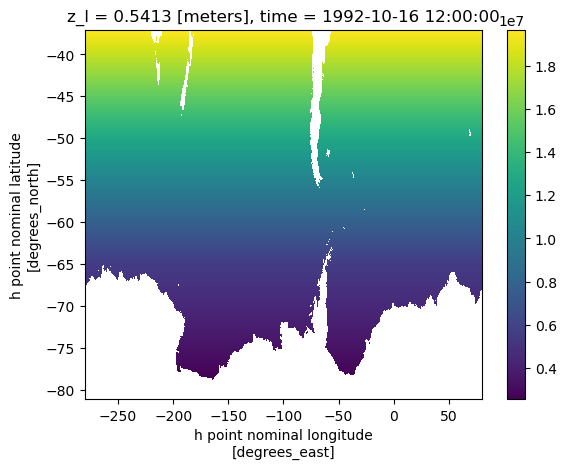

In [33]:
area_corr = area*(var*0 +1)
area_corr.plot()

In [34]:
thickness = volcello / area_corr
thickness = thickness.sel(yh=slice(-80, -59)).sel(z_l=slice(None, 500))

In [35]:
thickness

<xarray.DataArray (z_l: 39, yh: 967, xh: 7200)> Size: 1GB
dask.array<truediv, shape=(39, 967, 7200), dtype=float32, chunksize=(39, 512, 600), chunktype=numpy.ndarray>
Coordinates:
  * xh       (xh) float64 58kB -280.0 -279.9 -279.9 -279.8 ... 79.87 79.92 79.97
  * yh       (yh) float64 8kB -80.0 -79.98 -79.96 ... -59.07 -59.05 -59.02
  * z_l      (z_l) float64 312B 0.5413 1.681 2.94 4.332 ... 383.0 423.7 468.4
    time     object 8B 1992-10-16 12:00:00

In [36]:
# Depth average gives us the barotropic velocity
barotropic_alongslope_velocity_C = (alongslope_velocity_C * thickness).sum('z_l') / thickness.sum('z_l')
barotropic_alongslope_velocity_MW = (alongslope_velocity_MW * thickness).sum('z_l') / thickness.sum('z_l')

In [37]:
barotropic_alongslope_velocity_C = barotropic_alongslope_velocity_C.load()

In [38]:
barotropic_alongslope_velocity_MW = barotropic_alongslope_velocity_MW.load()

2025-10-10 13:14:18,043 - distributed.worker - ERROR - failed during get data with tcp://127.0.0.1:35997 -> tcp://127.0.0.1:36901
Traceback (most recent call last):
  File "/g/data/xp65/public/apps/med_conda/envs/analysis3-24.07/lib/python3.11/site-packages/tornado/iostream.py", line 861, in _read_to_buffer
    bytes_read = self.read_from_fd(buf)
                 ^^^^^^^^^^^^^^^^^^^^^^
  File "/g/data/xp65/public/apps/med_conda/envs/analysis3-24.07/lib/python3.11/site-packages/tornado/iostream.py", line 1116, in read_from_fd
    return self.socket.recv_into(buf, len(buf))
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TimeoutError: [Errno 110] Connection timed out

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/g/data/xp65/public/apps/med_conda/envs/analysis3-24.07/lib/python3.11/site-packages/distributed/worker.py", line 1797, in get_data
    response = await comm.read(deserializers=serializers)
               ^^^^^^^

In [39]:
barotropic_alongslope_velocity_MW

<xarray.DataArray (yh: 967, xh: 7200)> Size: 28MB
array([[        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       ...,
       [-0.03591928, -0.04159204, -0.04741795, ...,  0.01226966,
        -0.00937061, -0.02884744],
       [-0.03497692, -0.04271954, -0.04649537, ...,  0.00776294,
        -0.01123272, -0.02686228],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]], dtype=float32)
Coordinates:
  * xh       (xh) float64 58kB -280.0 -279.9 -279.9 -279.8 ... 79.87 79.92 79.97
  * yh       (yh) float64 8kB -80.0 -79.98 -79.96 ... -59.07 -59.05 -59.02
    time     object 8B 1992-10-16 12:00:00

In [40]:
barotropic_alongslope_velocity_anom = barotropic_alongslope_velocity_MW - barotropic_alongslope_velocity_C

In [41]:
barotropic_alongslope_velocity_C.to_netcdf('/g/data/g40/kc5856/thesis_figures/data_files/resolution_barotopic_slope_velocity_cont_pan005.nc')
barotropic_alongslope_velocity_MW.to_netcdf('/g/data/g40/kc5856/thesis_figures/data_files/resolution_barotopic_slope_velocity_melt_pan005.nc')
barotropic_alongslope_velocity_anom.to_netcdf('/g/data/g40/kc5856/thesis_figures/data_files/resolution_barotopic_slope_velocity_anom_pan005.nc')

# Plotting

In [42]:
theta  = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.275
verts  = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

In [43]:
land_50m = cft.NaturalEarthFeature("physical", "land", "50m", edgecolor="black", facecolor="papayawhip", linewidth=0.5)
projection = ccrs.SouthPolarStereo()

In [44]:
def shelf_mask_isobath(var, model_dict):

    paths = {"mom5": "/g/data/ik11/grids/Antarctic_slope_contour_1000m.npz",
             "mom6_01": "/g/data/ik11/grids/Antarctic_slope_contour_1000m_MOM6_01deg.nc", 
             }

    var = var.cf.sel({'latitude': slice(-90, -59)})

    if paths[model_dict][-3:] == '.nc':
        shelf_mask = xr.open_dataset(paths[model_dict])['contour_masked_above']
    else:
        contour_file = np.load(paths[model_dict])
        shelf_mask = xr.DataArray(contour_file['contour_masked_above'],
                                  coords = var.coords, 
                                  dims = var.dims,
                                  name = 'contour_masked_above')
    
    shelf_mask = xr.where(shelf_mask == 0, 1, 0)
    masked_var = var * shelf_mask
    
    return masked_var, shelf_mask

In [45]:
land_mask = (depth*0).fillna(1)
depth_shelf, shelf_mask = shelf_mask_isobath(depth, 'mom6_01')
land = xr.where(np.isnan(depth.rename('land')), 1, np.nan)

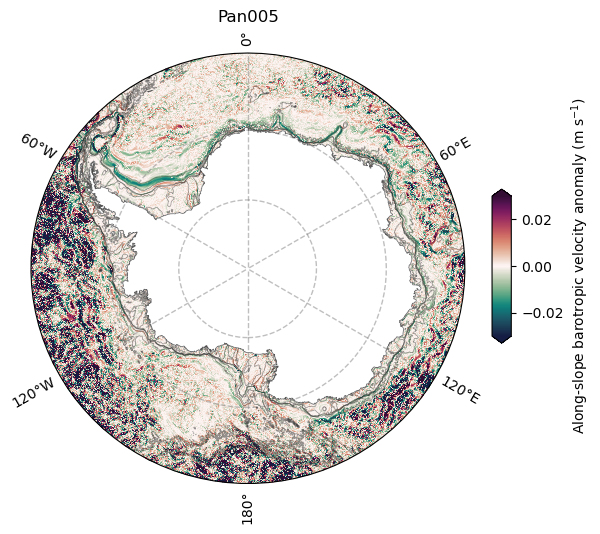

In [47]:
projection = ccrs.SouthPolarStereo()
    
plt.figure(figsize=(7, 8))
ax = plt.axes(projection=projection)
ax.set_extent([-280, 80, -80, -59], crs=ccrs.PlateCarree())

# Circular boundary
theta = np.linspace(0, 2 * np.pi, 100)
center, radius = [0.5,0.495], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

# Filled land 
land.plot.contourf(ax=ax, colors='white',
                   zorder=2,
                   transform=ccrs.PlateCarree(),
                   add_colorbar=False)

# Coast line
ax.contour(land_mask.cf['X'], land_mask.cf['Y'], land_mask,
           levels = [0, 1], colors = 'dimgrey',linewidths=0.5, transform = ccrs.PlateCarree())
# Shelf contour
ax.contour(shelf_mask.cf['X'], shelf_mask.cf['Y'], shelf_mask,
           levels = [0, 1], colors = 'k', linewidths=0.1,transform = ccrs.PlateCarree())

# Adding polar axes
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, 
                    xlocs=range(-180,171,60), ylocs=[], 
                    color='gray', alpha=0.5, linestyle='--', zorder=10)
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linewidth=1, 
                    xlocs=[], ylocs=(-80,-70,-55), 
                    color='gray', alpha=0.5, linestyle='--', zorder=10)

# Depth contours
depth.plot.contour(ax=ax, levels=[500, 1000, 2000, 3000],
                colors='0.2', linewidths=[0.5, 0.75, 0.5, 0.5], alpha=0.5,
                transform=ccrs.PlateCarree())

# Along slope barotropic velocity
sc = barotropic_alongslope_velocity_anom.plot(ax=ax, cmap=cm.cm.curl,
                                         transform=ccrs.PlateCarree(),
                                         vmin=-0.03, vmax=0.03,
                                         cbar_kwargs={'orientation': 'vertical',
                                                      'shrink': 0.25,
                                                      'extend': 'both',
                                                      'label': 'Along-slope barotropic velocity anomaly (m s$^{-1}$)',
                                                      'aspect': 8})
  
ax.set_title('Pan005');